In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import PIL
from PIL import Image
import random
import csv

/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
img_name = "./img_rename/mukudori/mukudori_0.jpeg"
img = cv2.imread(img_name)

In [6]:
# ルックアップテーブルの生成
min_table = 50
max_table = 205
diff_table = max_table - min_table

LUT_HC = np.arange(256, dtype = 'uint8' )
LUT_LC = np.arange(256, dtype = 'uint8' )

# ハイコントラストLUT作成
for i in range(0, min_table):
    LUT_HC[i] = 0
for i in range(min_table, max_table):
    LUT_HC[i] = 255 * (i - min_table) / diff_table
for i in range(max_table, 255):
    LUT_HC[i] = 255

# ローコントラストLUT作成
for i in range(256):
    LUT_LC[i] = min_table + i * (diff_table) / 255

# 変換
high_cont_img = cv2.LUT(img, LUT_HC)
low_cont_img = cv2.LUT(img, LUT_LC)

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/core/src/matrix.cpp:405: error: (-215:Assertion failed) m.dims >= 2 in function 'Mat'


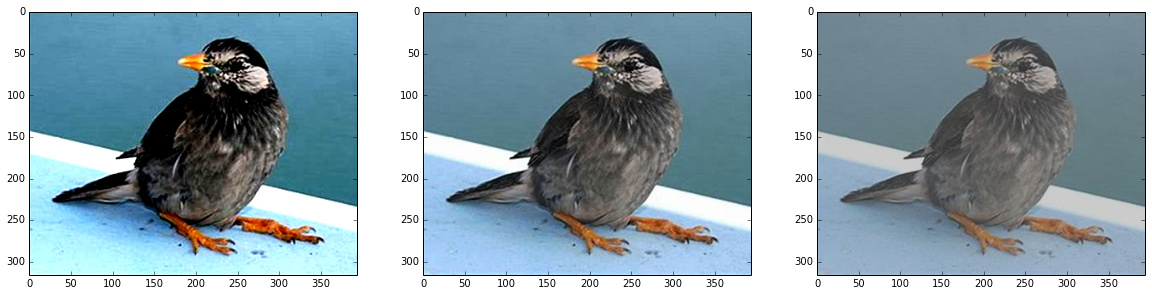

In [5]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(high_cont_img, cv2.COLOR_BGR2RGB)) #表示
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ) #表示
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(low_cont_img, cv2.COLOR_BGR2RGB)) #表示
plt.show()

In [2]:
def draw_images(generator, x, dir_name, index):
    # 出力ファイルの設定
    save_name = 'extened-' + str(index)
    g = generator.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix=save_name, save_format='jpg')

    # 1つの入力画像から何枚拡張するかを指定
    # g.next()の回数分拡張される
    for i in range(100):
        bach = g.next()

In [4]:
import PIL, os
# 出力先ディレクトリの設定
output_dir = "dataset_edited_3/expand/suzume"
if not(os.path.exists(output_dir)):
    os.mkdir(output_dir)

# 拡張する画像群の読み込み
images = glob.glob(os.path.join('./dataset_edited_3/suzume/', "*.jpeg"))

# 拡張する際の設定
generator = ImageDataGenerator(
                rotation_range=90, # 90°まで回転
                width_shift_range=0.1, # 水平方向にランダムでシフト
                height_shift_range=0.1, # 垂直方向にランダムでシフト
                channel_shift_range=50.0, # 色調をランダム変更
                shear_range=0.39, # 斜め方向(pi/8まで)に引っ張る
                horizontal_flip=True, # 垂直方向にランダムで反転
                vertical_flip=True # 水平方向にランダムで反転
                )

# 読み込んだ画像を順に拡張
for i in range(len(images)):
    img = load_img(images[i])
    # 画像を配列化して転置a
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # 画像の拡張
    draw_images(generator, x, output_dir, i)

In [125]:
# 画像のリサイズ
# mukudori: 1139
# suzume: 970
base_dir = './dataset_3/extended/'
target_dir = './dataset_3/resized/'
dir_names = [['mukudori', 1139], ['suzume', 968]]

for dir_name, data_num in dir_names:
    for i in range(data_num):
        index = str(i)
        image = Image.open(base_dir+dir_name+"/"+dir_name+"_"+index+".jpeg")
        image = image.resize((28,28))
        
        if(os.path.isfile(target_dir+dir_name+"/"+dir_name+"_"+index+".jpeg")):
            os.remove(target_dir+dir_name+"/"+dir_name+"_"+index+".jpeg")
        image.save(target_dir+dir_name+"/"+dir_name+"_"+index+".jpeg")

In [126]:
m_num, s_num = 1139, 968
m_label, s_label = [], []
m_dir, s_dir = './dataset_3/resized/mukudori/', './dataset_3/resized/suzume/'

for i in range(m_num):
    m_label.append(0)
for j in range(s_num):
    s_label.append(0)

#for mukudori
for i in range(m_num):
    index = str(i)
    m_label[i] = Image.open(m_dir+'mukudori_'+index+'.jpeg')
    width, height = m_label[i].size

    img_pixels = []
    for y in range(height):
        for x in range(width):
            img_pixels.append(m_label[i].getpixel((x, y)))
    
    m_label[i] = np.array(img_pixels)
    m_label[i] = np.reshape(m_label[i], (28, 28, 3))

#for suzume
for i in range(s_num):
    index = str(i)
    s_label[i] = Image.open(s_dir+'suzume_'+index+'.jpeg')
    width, height = s_label[i].size

    img_pixels = []
    for y in range(height):
        for x in range(width):
            img_pixels.append(s_label[i].getpixel((x, y)))
    
    s_label[i] = np.array(img_pixels)
    s_label[i] = np.reshape(s_label[i], (28, 28, 3))

In [128]:
data = m_label + s_label
label = []

for i in range(len(m_label)):
    label.append([1, 0])
for j in range(len(s_label)):
    label.append([0, 1])

In [129]:
from sklearn.model_selection import train_test_split

D_train, D_test, L_train, L_test = train_test_split(data, label, test_size=0.3)

In [99]:
np.save('./dataset_1/data/D_train', D_train)
np.save('./dataset_1/data/D_test', D_test)
np.save('./dataset_1/data/L_train', L_train)
np.save('./dataset_1/data/L_test', L_test)

In [46]:
# ↑ データ準備
# ==============
# ↓　学習

In [130]:
#入力用プレースホルダー
x=tf.placeholder(tf.float32)

#重み作る
def weight_variable(shape,name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial,name=name)
#バイアス作る
def bias_variable(shape,name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial,name=name)
#畳み込み演算
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#プーリング演算
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')



#一つ目のweight,bias,5*5のフィルター,RGB3,出力32

W_conv1 = weight_variable([5, 5, 3, 32],"W_conv1")
b_conv1 = bias_variable([32],"b_conv1")


#畳み込み1、プーリング1

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


#二つ目のweight,bias

W_conv2 = weight_variable([5, 5, 32, 64],"W_conv2")
b_conv2 = bias_variable([64],"b_conv2")

#畳み込み2、プーリング2

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#三つめのweight,bias

W_fc1 = weight_variable([7 * 7 * 64, 1024],"W_fc1")
b_fc1 = bias_variable([1024],"b_fc1")

#全結合層　一次元に直す

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


#ドロップアウト

keep_prob=tf.placeholder(tf.float32)
h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)

#四つ目のweight,bias

W_fc2 = weight_variable([1024, 2],"W_fc2")
b_fc2 = bias_variable([2],"b_fc2")

#出力

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#正解ラベル

right_rabel=tf.placeholder(tf.float32)

#損失関数

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=right_rabel, logits=y_conv))

#交差エントロピーを減らす
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

#学習する
print()
tr=tf.placeholder(tf.float32)

#正解ラベルとの一致を調べる
correct_prediction=tf.equal(tf.argmax(tr,1),tf.argmax(y_conv,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#バッチ入れる箱
batch=[]
batch_rabels=[]

sess=tf.InteractiveSession()
init=tf.global_variables_initializer()
sess.run(init)

for i in range(int(1000)):
    batch=[]
    batch_rabels=[]
    
    #バッチを作る
    for a in range(20):
        b=random.randint(0,len(D_train)-1) #
        batch.append(D_train[b])
        batch_rabels.append(L_train[b])
    #学習実行
    sess.run(train_step,feed_dict={x:batch,right_rabel:batch_rabels,keep_prob:0.5})
    if(i%100==0):
        #出力を出力
        print(sess.run(y_conv,feed_dict={x:D_test,right_rabel:L_test,keep_prob:1.0}))

    #テストデータで確認する

    if(i%10==0):
        print([i, int(1000)-1])
        print(sess.run(accuracy,feed_dict={x:D_test,tr:L_test,keep_prob:1.0}))

    #最終的な精度

    if(i==int((1000)-1)):
        print(sess.run(accuracy, feed_dict={x: D_test, tr: L_test, keep_prob: 1.0}))

#学習済みデータを保存

saver_orig=tf.train.Saver()
saver_orig.save(sess, "./model5.ckpt")

()
[[-1006.21625  1055.7194 ]
 [ -427.17273   835.7092 ]
 [ -577.2298    808.4661 ]
 ...
 [  854.27466  1629.1381 ]
 [-1102.4552   1085.2709 ]
 [ -782.61      781.9366 ]]
[0, 999]
0.44865718
[10, 999]
0.54818326
[20, 999]
0.5560821
[30, 999]
0.6666667
[40, 999]
0.6793049
[50, 999]
0.65560824
[60, 999]
0.65560824
[70, 999]
0.6793049
[80, 999]
0.65244865
[90, 999]
0.67456555
[[ -7.2756386  19.015564 ]
 [ 35.847027   11.632322 ]
 [  4.8041635  12.738288 ]
 ...
 [ 12.079166  259.30453  ]
 [ 23.467148   -3.5534346]
 [ -1.6214497  14.422827 ]]
[100, 999]
0.70616114
[110, 999]
0.7093207
[120, 999]
0.71406
[130, 999]
0.69036335
[140, 999]
0.67140603
[150, 999]
0.6982622
[160, 999]
0.68088466
[170, 999]
0.6824645
[180, 999]
0.6982622
[190, 999]
0.70300156
[[ -4.5206656   14.26264   ]
 [  6.9300995    5.9365916 ]
 [  3.7861578    1.224782  ]
 ...
 [ 10.448386   157.99988   ]
 [  0.72239655   2.18493   ]
 [ -0.24123651   0.4914511 ]]
[200, 999]
0.6951027
[210, 999]
0.67140603
[220, 999]
0.6793049

'./model5.ckpt'

In [131]:
summary_writer = tf.summary.FileWriter('./test', graph = sess.graph)

In [109]:
saver = saver_orig

In [116]:
#学習済みパラメーターを用いて、画像をクラス分類する関数

def evaluation(img_path):

    #画像を読み込んで、配列に直す

    image_r=[0]

    image_r[0] = Image.open(img_path)
    #(28,28)に直す
    image_r[0]=image_r[0].resize((28,28))

    # オリジナル画像の幅と高さを取得
    width, height = image_r[0].size

    img_pixels = []
    for y in range(height):
        for x in range(width):
            # getpixel((x,y))で左からx番目,上からy番目のピクセルの色を取得し、img_pixelsに追加する
            img_pixels.append(image_r[0].getpixel((x, y)))

    #RGBかどうか判定して、それぞれ処理
    if (not (isinstance(img_pixels[0], int))):

        if (len(img_pixels[0]) == 3):
            # numpyのarrayに変換する
            image_r[0] = np.array(img_pixels)
            #(28,28),RGBに変形
            image_r[0] = np.reshape(image_r[0], (1,28, 28, 3))
    else:
        for a in range(784):
            #グレースケールは無理矢理RGBにする
            img_pixels[a] = [img_pixels[a], 1, 1]
        image_r[0] = np.array(img_pixels)
        image_r[0] = np.reshape(image_r[0], (1,28, 28, 3))

    #配列をクラス分類する
    #重み作る
    def weight_variable(shape,name):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial,name=name)
    #バイアス作る
    def bias_variable(shape,name):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial,name=name)
    #畳み込み作る
    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
     #プーリング作る
    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    #入力用
    x=tf.placeholder(tf.float32)

    #weight1,bias1,5*5のフィルター,RGB3,出力32

    W_conv1 = weight_variable([5, 5, 3, 32],"W_conv1")
    b_conv1 = bias_variable([32],"b_conv1")


    #畳み込み演算1,プーリング1

    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)


    #二つ目のweight,bias

    W_conv2 = weight_variable([5, 5, 32, 64],"W_conv2")
    b_conv2 = bias_variable([64],"b_conv2")

    #畳み込み2,プーリング2

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    #weight3,bias3

    W_fc1 = weight_variable([7 * 7 * 64, 1024],"W_fc1")
    b_fc1 = bias_variable([1024],"b_fc1")

    # 全結合層　一次元に直す

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


    #ドロップアウト

    keep_prob=tf.placeholder(tf.float32)
    h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)

    #weight4,bias4

    W_fc2 = weight_variable([1024, 2],"W_fc2")
    b_fc2 = bias_variable([2],"b_fc2")

    #出力

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    #latteの正解ラベル

    right_rabel=[0,1]

    #学習済みデータ読み込み

    ckpt_path="./model4.ckpt"
#     ckpt_path="./model4.ckpt.data-00000-of-00001"

    sess=tf.InteractiveSession()
    saver=tf.train.Saver()
    saver.restore(sess,ckpt_path)

    #判定を確認

    right=tf.constant(right_rabel)
    #正解ラベルと一致しているか調べる
    correct_prediction=tf.equal(tf.argmax(right,0),tf.argmax(y_conv,0))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    decision=sess.run(accuracy,feed_dict={x:image_r[0],keep_prob:1.0})
    result="failed"
    if(decision==1.0):
        result="latte"
    if(decision==0.0):
        result="other"

    return result

evaluation('original_img/mukudori/mukudori_0.jpeg')

INFO:tensorflow:Restoring parameters from ./model4.ckpt


NotFoundError: Key W_conv1_18 not found in checkpoint
	 [[Node: save_13/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_13/Const_0_0, save_13/RestoreV2/tensor_names, save_13/RestoreV2/shape_and_slices)]]

Caused by op u'save_13/RestoreV2', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2824, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-116-a68c0669439a>", line 132, in <module>
    evaluation('original_img/mukudori/mukudori_0.jpeg')
  File "<ipython-input-116-a68c0669439a>", line 114, in evaluation
    saver=tf.train.Saver()
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1311, in __init__
    self.build()
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1320, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1357, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 809, in _build_internal
    restore_sequentially, reshape)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 448, in _AddRestoreOps
    restore_sequentially)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 860, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1458, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/Users/noon/src/python/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key W_conv1_18 not found in checkpoint
	 [[Node: save_13/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_13/Const_0_0, save_13/RestoreV2/tensor_names, save_13/RestoreV2/shape_and_slices)]]
